In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/facebook-ad-campaign/data.csv


In [2]:
# import necessary libraries 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns 
sns.set_style('darkgrid')

import warnings
warnings.filterwarnings("ignore")

In [3]:
# import the data 
adv_df = pd.read_csv('/kaggle/input/facebook-ad-campaign/data.csv')
adv_df.head()

,ad_id,reporting_start,reporting_end,campaign_id,fb_campaign_id,age,gender,interest1,interest2,interest3,impressions,clicks,spent,total_conversion,approved_conversion
0,708746,17/08/2017,17/08/2017,916,103916,30-34,M,15,17,17,7350.0,1,1.43,2.0,1.0
1,708749,17/08/2017,17/08/2017,916,103917,30-34,M,16,19,21,17861.0,2,1.82,2.0,0.0
2,708771,17/08/2017,17/08/2017,916,103920,30-34,M,20,25,22,693.0,0,0.00,1.0,0.0
3,708815,30/08/2017,30/08/2017,916,103928,30-34,M,28,32,32,4259.0,1,1.25,1.0,0.0
4,708818,17/08/2017,17/08/2017,916,103928,30-34,M,28,33,32,4133.0,1,1.29,1.0,1.0


# Facebook Ad Campaign Data
---

## 📘 **Background of the Data**

This dataset contains performance data of **Facebook ads** run over different time periods. It captures various dimensions like **audience segmentation (age, gender, interests)**, **campaign identifiers**, and **performance metrics** such as impressions, clicks, spend, and conversions.


## 📊 **Column-wise Explanation**

| Column Name                           | Description                                                                     |
| ------------------------------------- | ------------------------------------------------------------------------------- |
| `ad_id`                               | Unique identifier for each ad.                                                  |
| `reporting_start`                     | Start date of the ad's reporting period.                                        |
| `reporting_end`                       | End date of the ad's reporting period.                                          |
| `campaign_id`                         | Internal campaign identifier.                                                   |
| `fb_campaign_id`                      | Facebook's campaign ID used for targeting and tracking.                         |
| `age`                                 | Age group targeted by the ad (e.g., 30-34).                                     |
| `gender`                              | Gender targeted (`M` or `F`).                                                   |
| `interest1`, `interest2`, `interest3` | Encoded user interest categories used for targeting (e.g., sports, fashion).    |
| `impressions`                         | Number of times the ad was shown to users.                                      |
| `clicks`                              | Number of times users clicked the ad.                                           |
| `spent`                               | Total money spent (in USD) on the ad.                                           |
| `total_conversion`                    | Total number of actions taken after the ad (e.g., signing up, visiting a page). |
| `approved_conversion`                 | Subset of total conversions that were approved (e.g., verified signups).        |


## 🎯 **Project Goal**

> **Objective**: To evaluate and optimize Facebook ad campaign performance by identifying the most effective targeting strategies (age, gender, interests) that lead to higher conversions and lower cost per acquisition (CPA).

---
---


In [4]:
adv_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1143 entries, 0 to 1142
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ad_id                1143 non-null   int64  
 1   reporting_start      1143 non-null   object 
 2   reporting_end        1143 non-null   object 
 3   campaign_id          1143 non-null   object 
 4   fb_campaign_id       1143 non-null   object 
 5   age                  1143 non-null   object 
 6   gender               1143 non-null   object 
 7   interest1            1143 non-null   int64  
 8   interest2            1143 non-null   int64  
 9   interest3            1143 non-null   int64  
 10  impressions          1143 non-null   float64
 11  clicks               1143 non-null   int64  
 12  spent                1143 non-null   float64
 13  total_conversion     761 non-null    float64
 14  approved_conversion  761 non-null    float64
dtypes: float64(4), int64(5), object(6)
mem

# Imputation Strategy for `total_conversion` and `approved_conversion`

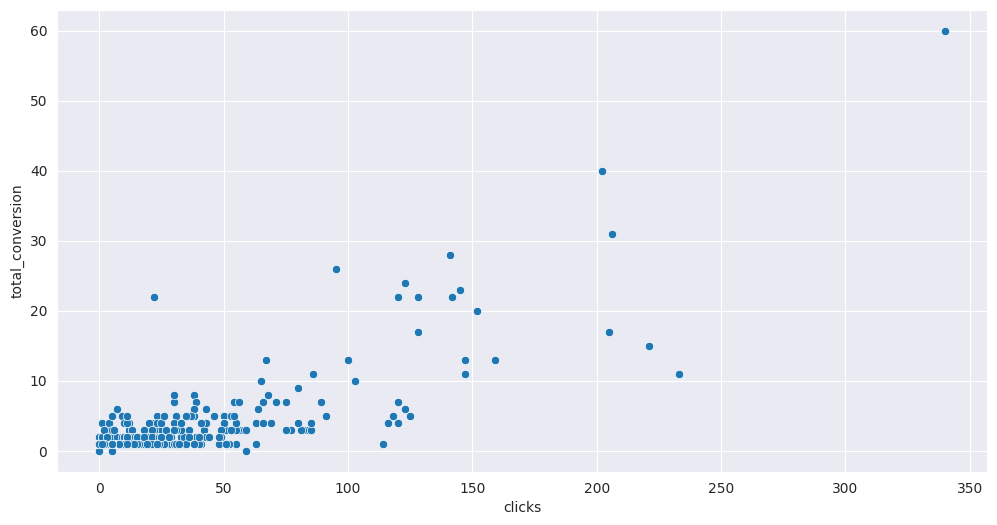

In [5]:
plt.figure(figsize=(12,6))
sns.scatterplot(x = adv_df['clicks'],y = adv_df['total_conversion'])
plt.show()

## ✅ Hybrid Strategy to Impute `total_conversion`

1. If `clicks == 0` → `total_conversion = 0`
2. If `clicks > 0` and missing → Fill with `clicks * average_conversion_rate` (or segment-wise rate)

This ensures you use **realistic and explainable values** rather than dropping rows or blindly filling with mean/median.

---


In [6]:
# If clicks == 0 → total_conversion = 0 ( for values where total_conversion is NaN)
adv_df.loc[(adv_df['clicks']==0) & (adv_df['total_conversion'].isna()), 'total_conversion'] = 0

In [7]:
adv_df.loc[(adv_df['clicks']==0)]['total_conversion'].value_counts()

total_conversion
1.0    192
2.0      8
0.0      6
Name: count, dtype: int64

There are 192 rows where `total_conversion` ia 1 but the `clicks` is 0 and 8 rows where `total_conversion` is 2 but the `clicks` is 0. It is possible since the click may have happended at an earlier date.

### 🛠️ Strategy to Fix Inconsistent Clicks Using Conversion Rate

In our dataset, there are **data quality issues** where:

* `clicks = 0` but `total_conversion > 0`

This is **illogical** because conversions can't happen without clicks.

#### ✅ Fixing the Issue Using Conversion Rate

To fix this, I will use the formula:

```python
clicks = total_conversion / conversion_rate
```

##### Why this works:

* **Conversion rate** is defined as:

  ```
  conversion_rate = total_conversion / clicks
  ⇒ clicks = total_conversion / conversion_rate
  ```
* So, if you **observe a typical conversion rate** from valid rows (where data is consistent), you can estimate the **missing or incorrect clicks**.

---


In [8]:
conversion_rate_df = adv_df.loc[adv_df['clicks'] > 0 & adv_df['total_conversion'].isna()]
# conversion_rate_df is the new df with clicks > 0 and total_conversion not null 

conversion_rate = conversion_rate_df['total_conversion'].sum() / conversion_rate_df['clicks'].sum()
conversion_rate

0.10810200857594222

In [9]:
# use conversion_rate to calculate the clicks where there is inconsistency i.e. clicks less than total_conversion
adv_df.loc[(adv_df['clicks']==0) & (adv_df['total_conversion']>0), 'clicks'] = round(adv_df['total_conversion']/conversion_rate)

In [10]:
# Next use the conversion rate to fill the nan values for the total_conversion 
adv_df.loc[adv_df['total_conversion'].isna(), 'total_conversion'] = round(adv_df['clicks'] * conversion_rate)

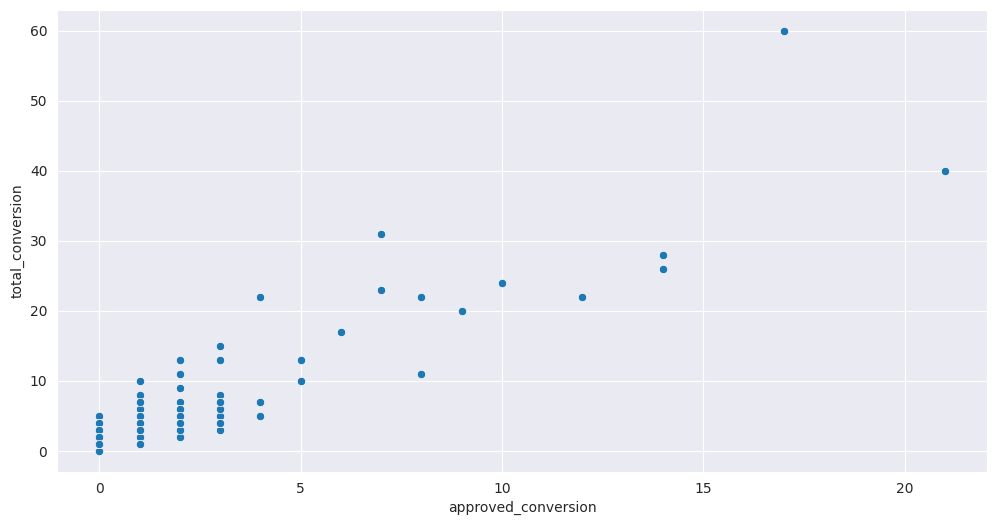

In [11]:
plt.figure(figsize=(12,6))
sns.scatterplot(x = adv_df['approved_conversion'],y = adv_df['total_conversion'])
plt.show()

From the data schema, it's likely that:

```
approved_conversion ≤ total_conversion
```

## ✅ Hybrid Strategy to Impute `approved_conversion`

- **If `total_conversion` is 0 or missing → approved\_conversion = 0**
- **If `approved_conversion` is missing and total\_conversion > 0 → Impute using average approval rate**


In [12]:
adv_df.loc[(adv_df['total_conversion'] == 0) & (adv_df['approved_conversion'].isna()), 'approved_conversion'] = 0

In [13]:
# compute avergae approval rate
approval_rate_series = adv_df['approved_conversion'] / adv_df['total_conversion']
avg_approval_rate = np.mean(approval_rate_series)
avg_approval_rate

0.3559820035939142

In [14]:
adv_df.loc[adv_df['approved_conversion'].isna(), 'approved_conversion'] = (adv_df['total_conversion'] * avg_approval_rate).round()

In [15]:
# let us see whether thera are missing values now
adv_df.isna().mean()

ad_id                  0.0
reporting_start        0.0
reporting_end          0.0
campaign_id            0.0
fb_campaign_id         0.0
age                    0.0
gender                 0.0
interest1              0.0
interest2              0.0
interest3              0.0
impressions            0.0
clicks                 0.0
spent                  0.0
total_conversion       0.0
approved_conversion    0.0
dtype: float64

# Data Cleaning

In [16]:
adv_df.sample(5)

,ad_id,reporting_start,reporting_end,campaign_id,fb_campaign_id,age,gender,interest1,interest2,interest3,impressions,clicks,spent,total_conversion,approved_conversion
312,778471,27/08/2017,27/08/2017,936,115856,30-34,M,32,35,36,1273.00,9,0.00,1.0,1.0
981,1122146,26/08/2017,26/08/2017,40-44,F,32,38,37,319501,79,111.65,0,0.00,0.0,0.0
837,1121763,28/08/2017,28/08/2017,30-34,F,19,22,23,87832,11,18.10,1,1.00,0.0,0.0
1087,1314351,23/08/2017,23/08/2017,45-49,M,110,114,111,188758,25,36.60,2,1.00,0.0,0.0
739,1121532,19/08/2017,19/08/2017,1178,144612,40-44,M,30,35,32,123126.00,25,39.73,2.0,1.0


## Cleaning `gender` column

In [17]:
adv_df.loc[(adv_df['fb_campaign_id']=='M') | (adv_df['fb_campaign_id']=='F'), 'gender'] = adv_df['fb_campaign_id']
adv_df['gender'].unique()

array(['M', 'F'], dtype=object)

## Cleaning `campaign_id`
> Note: There must be 3 distinct `campaign_id`

In [18]:
adv_df[['ad_id', 'campaign_id']].groupby(by='campaign_id').mean()

,ad_id
campaign_id,
1178,1.121325e+06
30-34,1.164595e+06
35-39,1.187025e+06
40-44,1.189805e+06
45-49,1.155344e+06
916,7.098885e+05
936,7.990632e+05


The rows like `"30-34"`, `"35-39"`, etc., are not actual IDs but instead appear to be **age groups** that were accidentally included in the `campaign_id` column, possibly due to a data misalignment or parsing issue.

### 🧠 Interpretation

* This implies that there was **data corruption or a column shift** — possibly while importing the data from a CSV or during a previous transformation step.
* All the rows with these age ranges likely belong to the same actual campaign, probably `1178`, as their `ad_id` average aligns closely with the known correct entries.

### ✅ What to Do Next?

1. **Filter these faulty entries** and inspect the rows where `campaign_id` is in an unexpected format (like strings).
2. **Correct the values** — potentially by moving the misplaced value to the correct `age` column.

### 📌 Brief Summary

> When grouping by `campaign_id`, non-numeric values like `30-34` appeared, which are actually age ranges mistakenly placed in the ID column. Their mean `ad_id` closely matches real campaign rows (e.g., `1178`), confirming a misalignment. This should be cleaned to ensure accurate campaign analysis.
---


In [19]:
adv_df['campaign_id'].unique()

array(['916', '936', '1178', '45-49', '30-34', '35-39', '40-44'],
      dtype=object)

In [20]:
#  moving the misplaced value to the correct age column.
adv_df.loc[adv_df['campaign_id'].isin(['45-49', '30-34', '35-39', '40-44']), 'age'] = adv_df['campaign_id']

In [21]:
# All the rows with these age ranges likely belong to the same actual campaign, probably 1178, 
# as their ad_id average aligns closely with the known correct entries.

adv_df.loc[adv_df['campaign_id'].isin(['45-49', '30-34', '35-39', '40-44']), 'campaign_id'] = '1178'
adv_df['campaign_id'].unique()

array(['916', '936', '1178'], dtype=object)

## Drop `fb_camapaign_id`

In [22]:
adv_df['ad_id'].nunique()

1143

Since `ad_id` uniquely identifies each row, I can drop the `fb_campaign_id` columns from the dataframe. 

In [23]:
adv_df = adv_df.drop(['fb_campaign_id'], axis=1)
adv_df.columns

Index(['ad_id', 'reporting_start', 'reporting_end', 'campaign_id', 'age',
       'gender', 'interest1', 'interest2', 'interest3', 'impressions',
       'clicks', 'spent', 'total_conversion', 'approved_conversion'],
      dtype='object')

# KPI = Key Performance Indicators 